# Free Drawn Spirals

For understanding the code in detail, please refer to the [PD_classification_Kamble](PD_classification_Kamble.ipynb) notebook.

We used this: [Dataset](https://www.kaggle.com/datasets/kmader/parkinsons-drawings/).

In [1]:
# import module
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize
from numba.typed import List
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from scipy import signal
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d
import os
import plantcv.plantcv.morphology.prune as prune

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import random

In [2]:

# Store Pdf with convert_from_path function
path = r'/Users/linusfalk/Dev/AIA/AIA/Varalakshmi/drawings/spiral'



V09PE03.png


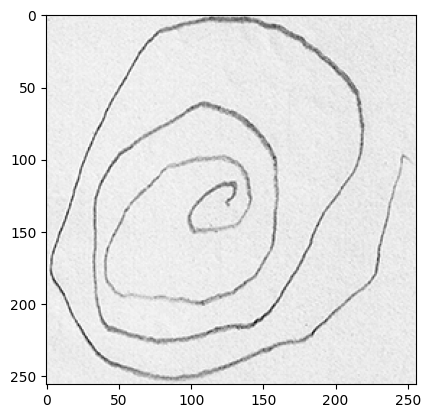

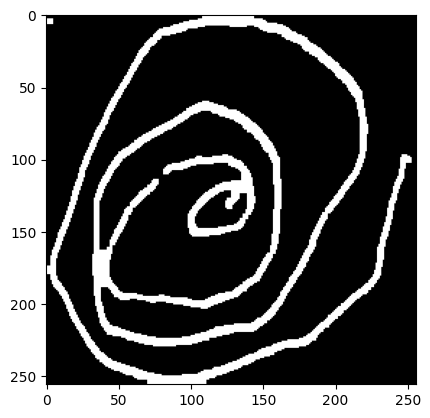

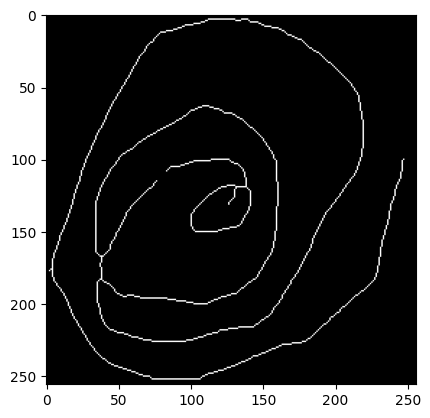

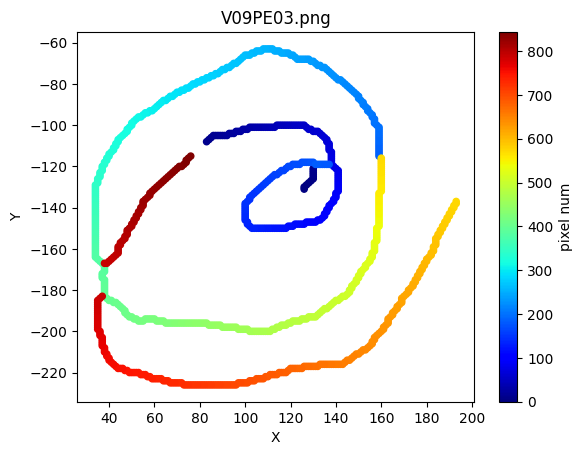

V09HE02.png
V55HE06.png
V55HE12.png
V10HE01.png
V10PE01.png
V55HE13.png
V55HE07.png
V09HE03.png
V09PE02.png
V09HE01.png
V55HE11.png
V55HE05.png
V10PE03.png
V10HE02.png
V10HE03.png
V10PE02.png
V55HE04.png
V55HE10.png
V09PE01.png
V08HE01.png
V55HE14.png
V01HE02.png
V11HE02.png
.DS_Store
file was skipped
V11PE03.png
V01PE03.png
V01PE02.png
V11PE02.png
V11HE03.png
V01HE03.png
V55HE01.png
V55HE15.png
V08PE01.png
V08HE02.png
V08PE03.png
V55HE03.png
V11HE01.png
V01HE01.png
V11PE01.png
V01PE01.png
V55HE02.png
V08PE02.png
V08HE03.png
V03PE03.png
V13PE03.png
V13PE02.png
V03PE02.png
V03PE01.png
V13PE01.png
V12HE01.png
V03PE05.png
V02HE01.png
V03PE04.png
V12PE01.png
V02PE01.png
V12PE03.png
V02PE03.png
V03PE06.png
V02HE02.png
V12HE02.png
V12HE03.png
V02HE03.png
V03PE07.png
V02PE02.png
V12PE02.png
V07HE03.png
V07PE02.png
V07PE03.png
V07HE02.png
V03PE09.png
V07PE01.png
V07HE01.png
V03PE08.png
V03HE1.png
V06PE01.png
V06HE01.png
V06PE02.png
V03HE2.png
V06HE03.png
V06HE02.png
V06PE03.png
V03HE3.png
V04P

In [3]:
names = []
trace_distances_all = []
trace_angle_all = []
all_paths = []
first = True

for file_path in os.listdir(path):
    print(file_path)
    
    # make sure file is .tiff
    if not file_path[-4:] == '.png':
        print('file was skipped')
        continue
        
    # preprocess image and create skeleton
    original  = cv2.imread(path + '//' + file_path, cv2.IMREAD_GRAYSCALE)
    tmp = original.copy()
    
    # threshold  
    tmp = cv2.adaptiveThreshold(tmp, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 99, 15)    
    tmp = np.array((tmp==0)*1, np.uint8)

    # opening
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)

    # dilating
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)

    # closing
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)

    # skeleonizing
    skl = skeletonize(tmp)
    skeleton_img_cropped = np.array(skl*1, np.uint8)
    skeleton_img_cropped, _, _ = prune(skeleton_img_cropped, size=10)

    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=50)
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
        
    # follow the start point through the spiral
    skeleton_img_trace = skeleton_img_cropped.copy()
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=50, neigbor=False, flipped_priority=True) #150
    trace_path_typed = List()
    [trace_path_typed.append(i) for i in trace_path]

    # turn the coordinates in angle and distance for an alternative representation
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(file_path)
    all_paths.append(trace_path)

    if first:
        plt.imshow(original, 'gray')
        plt.show()
        plt.imshow(tmp, 'grey')
        plt.show()
        plt.imshow(skeleton_img_cropped, 'grey')
        plt.show()
        plt_traced(trace_path, file_path)
    first = False
    #break

In [4]:
df = {}

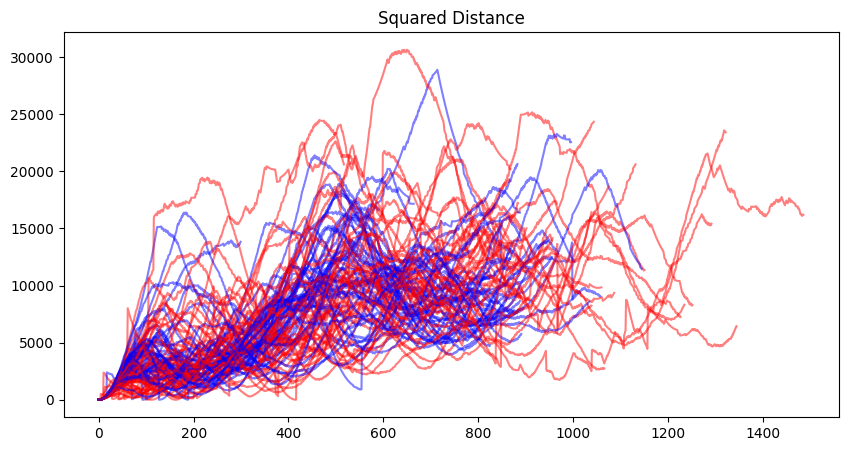

In [5]:
plt.figure(figsize=(10, 5))
for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    if True: #not 'dynamic' in name:
        x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
        reg = LinearRegression().fit(x, d2)
        pred = reg.predict(x)
        pad = 0
        d2 = list([0.0 for _ in range(pad)]) + list(d2)
        #print(d2)
        filtered = gaussian_filter1d(d2, 160)[pad:]
        filtered2 = gaussian_filter1d(d2, 30)[pad:]
        filtered3 = gaussian_filter1d(d2, 30)[pad:]
        d2 = d2[pad:]
        
        color = 'red' if 'PE' in name else 'blue'
        plt.plot(d2[:-500], c=color, alpha=0.5)
        #plt.plot(pred, c='k')
        #plt.plot(filtered2, c='lightgrey')

        df[name]['dist2'] = d2
        df[name]['dist2_linreg'] = pred
        df[name]['dist2_filtered'] = filtered
        df[name]['dist2_filtered2'] = filtered2
        df[name]['dist2_filtered3'] = filtered3
        
plt.title('Squared Distance')
plt.show()

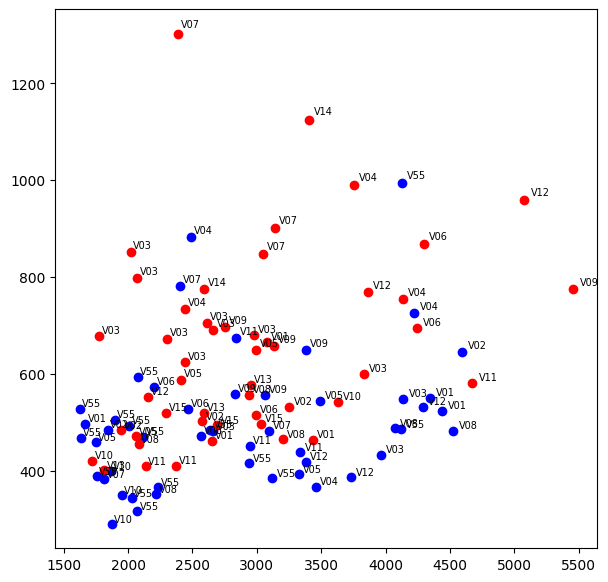

In [6]:
plt.figure(figsize=(7,7))
for name in df:
    if len(df[name]['dist2']) > 800:
        sa, ea = 10, -50
        sd, ed = 10, -50
        c = 'red' if 'PE' in name else 'blue'
        x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
        y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered3'][sa:ea])])
        plt.scatter(x, y, c=c)
        plt.text(x*1.01, y*1.01, name[:3], fontsize=7)

plt.show()

In [7]:
X_train, X_test = [], []
y_train, y_test = [], []
kns = 3
for b in [True, False]:
    tmpX, tmpy = [], []
    df_rand = list(df.keys())
    random.seed(3)
    random.shuffle(df_rand)
    for name in df_rand:
        if len(df[name]['dist2']) > 800:
            if (('PE' in name) == b):
                sa, ea = 10, -10
                sd, ed = 10, -10
                lbl = 1 if 'PE' in name else 0
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered3'][sa:ea])])
                tmpX.append([x, y])
                tmpy.append(lbl)
    
    X_test.extend(tmpX[-len(tmpX)//3:])
    X_train.extend(tmpX[:-len(tmpX)//3])
    #print(tmpy)
    y_test.extend(tmpy[-len(tmpy)//3:])
    y_train.extend(tmpy[:-len(tmpy)//3])

        

In [8]:
# use a Knn with k=3 see parameter tuning in our paper
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

acc_test = 100 * (cm_test[0, 0] + cm_test[1, 1]) / sum(sum(cm_test))
print(f'test accuracy: {acc_test:.2f}%')

[[26  7]
 [ 6 26]]
[[ 9  8]
 [ 7 10]]
test accuracy: 55.88%


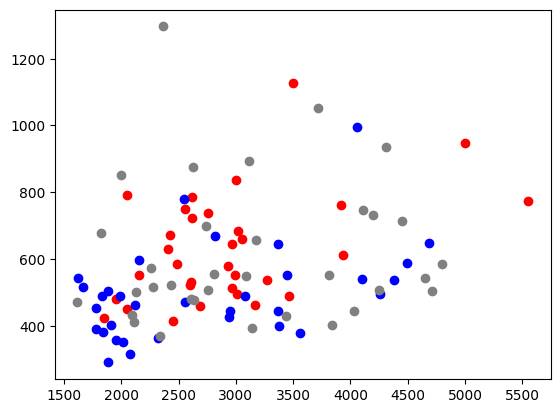

In [9]:
for X, y in zip(X_train, y_train):
    plt.scatter(X[0], X[1], c=['blue', 'red'][y])
for X in X_test:
    plt.scatter(X[0], X[1], c='grey')

#plt.plot([min(np.array(X_train)[:, 0]), max(np.array(X_train)[:, 0])], [-(clf.intercept_ + min(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1], -(clf.intercept_ + max(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1]], 'k')
#plt.xscale('log')
#plt.yscale('log')

### k-fold cross validation with different random split seeds

Average Accuracy: 0.6701263157894737
Standard devatation Accuracy: 0.09694902907315342


(array([  3.,   8.,  78., 166., 177.,  56.,  12.]),
 array([0.31578947, 0.40639098, 0.49699248, 0.58759398, 0.67819549,
        0.76879699, 0.8593985 , 0.95      ]),
 <BarContainer object of 7 artists>)

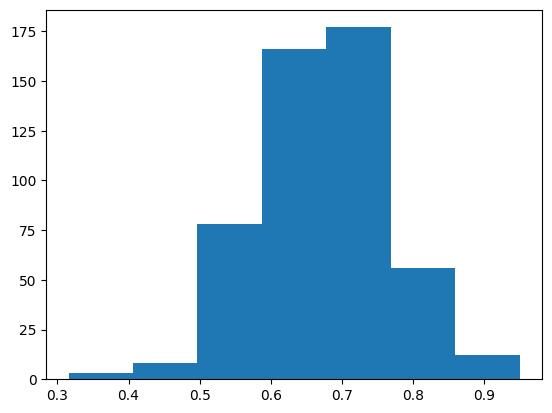

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

pd = []
healthy = []

for name in df:
        if len(df[name]['dist2']) > 800:
            if 'PE' in name:
                  pd.append(name)
            else:
                  healthy.append(name)


X = np.array(pd + healthy)
Y = np.array([1] * len(pd) + [0] * len(healthy))


# Number of folds
k = 5

# List to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []


model = LinearDiscriminantAnalysis()


for seed in range(100):

    # Create k-fold cross-validation object
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)


    # Perform k-fold cross validation
    for train_index, test_index in skf.split(X, Y):    # Split data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        X_train_data = []
        X_test_data = []

        for name in X_train:
                    x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                    y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                    X_train_data.append([x, y])
        
        for name in X_test:
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                X_test_data.append([x, y])

        
        # Fit the model
        model.fit(X_train_data, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_data)
        y_pred_prob = model.predict_proba(X_test_data)

        # Calculate and store the results
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
# Calculate average accuracy across all folds and splits
average_accuracy = np.mean(accuracies)
average_std = np.std(accuracies)

print(f"Average Accuracy: {average_accuracy}")
print(f"Standard devatation Accuracy: {average_std}")
plt.hist(accuracies, bins=7)

#### Example of ROC from one random split

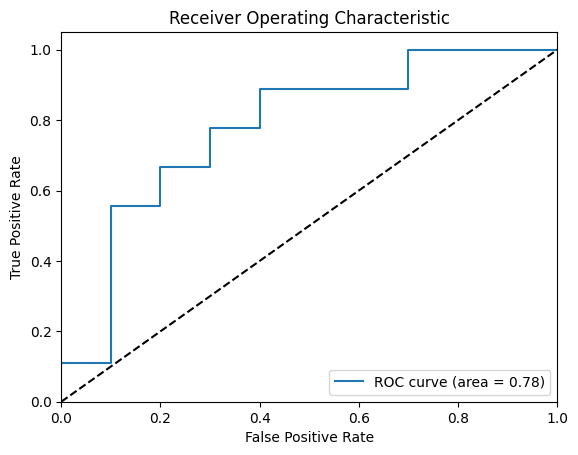

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1]) # y_pred_prob is the probability of the positive class
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
